In [1]:
from eoxhub import check_compatibility
check_compatibility("user-2022.06-03", dependencies=["SH", "GEODB"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`
* `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_DOMAIN`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_API_SERVER_PORT`


# Environmental Impacts of Lockdown in Venice, Italy during 2020

## Geo-storytelling with EODASHBOARD and the Euro Data Cube - Notebook #2

This notebook looks at the impact of the mobility restrictions imposed in the Italian region Veneto during the Covid-19 pandemic to restrict the spread of the virus. 

It uses Earth Observation data from ESA, NASA and JAXA from the [EO Dashboard](https://eodashboard.org), together with other geospatial data as well as non-EO information.

To read more about the tri-agency collaboration visit https://eodashboard.org. 

## In this Notebook:

1. [We download and plot open data about mobility over the region of Veneto and determine extreme values associated with the lockdown](#Covid-Mobility-Data-from-Google)
2. [We then access vessel density data in the venice Lagoon and evaluate the reduction in vessel traffic during the lockdown](#Requesting-Vessel-Density-Data)
3. [Using the extreme value's date as a proxy for the period of reduced activity, we request NASA nightlight data and visually inspect if changes are visible](#Using-the-NASA-API-to-retreive-nightlights-data)
4. [We inspect whether an environmental impact of the activity reduciton is visible in the water quality in the lagoon by visually inspecting Copernicus Sentinel-2 imagery](#Retreiving-Sentinel-2-imagery-over-the-Island-of-Venice)
5. [We proceed to access and visualise Chlorophyll-a concentration maps in the Venice lagoon](#Requesting-Water-Quality-Data-from-JAXA)
6. [We access water quality time series and inspect the Chlorophyll-a variation compared to the climatology](#Retreiving-water-quality-time-series-from-GeoDB)

### Permissions and Package Download

In [2]:
#Import necessary packages

import concurrent.futures
import datetime as dt
from ipyleaflet import basemaps, Map, GeoJSON
import json
import requests as re
import matplotlib.pyplot as plt
import pprint
import time
import datetime
import csv
import requests
import numpy as np
import sys
import pandas as pd
import geojson
import requests as re
from ipyleaflet import Map, basemaps, basemap_to_tiles, TileLayer, SplitMapControl
import warnings
warnings.filterwarnings('ignore')

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.patches as mpatches


# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

In [3]:
# Time Series data in Step 6. are store in the geodatabase, so we check if the xcube_geodb service is active

from edc import check_compatibility
from xcube_geodb.core.geodb import GeoDBClient
geodb = GeoDBClient()
geodb.whoami

'geodb_418dfeac-15f0-4606-9edb-fd9eb722bf04'

In [4]:
# Sentinel-2 imagery and the water quality maps that we use in Steps 4. and 5. will be accessed from the Sentinel Hub. 
# Here we make sure that the data needed for the authentication to use the Sentinel Hub services is available, and we establish a session 

import os
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
# Your client credentials
client_id = os.environ['SH_CLIENT_ID']
client_secret = os.environ['SH_CLIENT_SECRET']
# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)
# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
# Sentinel Hub
from sentinelhub import (MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, 
                         DataCollection, bbox_to_dimensions, DownloadRequest, SHConfig)

In [5]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

## Covid Mobility Data from Google

Google provides open data on mobility, called "Google COVID-19 Community Mobility Reports". To access the original data source, visit: https://www.google.com/covid19/mobility/ 

In EO Dashboard this indicator is called "Mobility Data" and provides country-level aggregated charts. On EO Dashboard it can be accessed at: https://eodashboard.org/explore?indicator=GG. 

All charts and maps on EO Dashboard provide an "embed link" and we will use this together with the IFrame library to inspect the mobility trends at country level for Italy. 

**Tip: try interacting with the chart, zoom in/out, activate/deactivate categories by clicking on the legend items, hover over the chart to get more details**


In [6]:
# How Mobility data is presented in EO Dashboard

from IPython.display import IFrame
IFrame('https://eodashboard.org/iframe?poi=IT-GG', width=800, height=500)

### Mobility in Veneto 

We want to focus only on the region of Veneto, not the entire country, as we will use the COVID Mobility data to relate lockdowns to changing behaviour in the region and especially in the Venice lagoon. 

We use this data to estimate the times where the lockdown restrictions were at their highest and inturn relate this to activity and finaly water quality.

The Covid Mobility data covers the larger area of Veneto, which includes the region of Venice. Below we display the region using NUTS data:

In [7]:
import requests
# First let us get the area information of the country from the administratives zones
# You can find all the different NUTS levels, resolution here: https://gisco-services.ec.europa.eu/distribution/v2/nuts/nuts-2021-files.html

response = requests.get(
    "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326_LEVL_2.geojson"
)

data = response.json()

# Now lets find the geometry information for one country
match = [x for x in data["features"] if x["properties"]["NUTS_ID"] == 'ITH3'][0]

In [8]:
import shapely.geometry
import IPython.display
IPython.display.GeoJSON(match)

<IPython.display.GeoJSON object>

In [9]:
# Download google mobilty dataset

url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

gfile = requests.get(url, allow_redirects=True)
open('gmobility_data.csv', 'wb').write(gfile.content)

1020499354

In [10]:
# open dataset and retrieve the data
with open('gmobility_data.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    country_data = {}
    # Le us say we interested in retail_and_recreation_percent_change_from_baseline in 3 countries, France, Italy and Austria
    countries = ["IT"]
    for key in countries:
        country_data[key] = []
    # We iterate through the csv rows and extract the wanted data
    for row in reader:
        # For now we skip subregional data and only look at overall country data
        # this is the case for countries that have no information on the following 3 parameters
        if row["sub_region_1"] == 'Veneto' and row["sub_region_2"] == '' and row["metro_area"] == '' :
            location_key = row["country_region_code"]

            if location_key in countries:
                country_data[location_key].append((
                    datetime.datetime.strptime(row["date"], "%Y-%m-%d"), # convert to date object
                    float(row["retail_and_recreation_percent_change_from_baseline"]) #convert to float
                ))

In [11]:
# creating a pandas dataframe to store the data
veneto = pd.DataFrame(country_data[key], columns=['date','retail_and_recreation_percent_change_from_baseline'])
veneto['date'] =  pd.to_datetime(veneto['date'], infer_datetime_format=True)
veneto_ts = veneto.set_index('date') 

In [12]:
# resampling the data
weekly_veneto = veneto_ts.resample('W').mean()

<AxesSubplot:xlabel='date'>

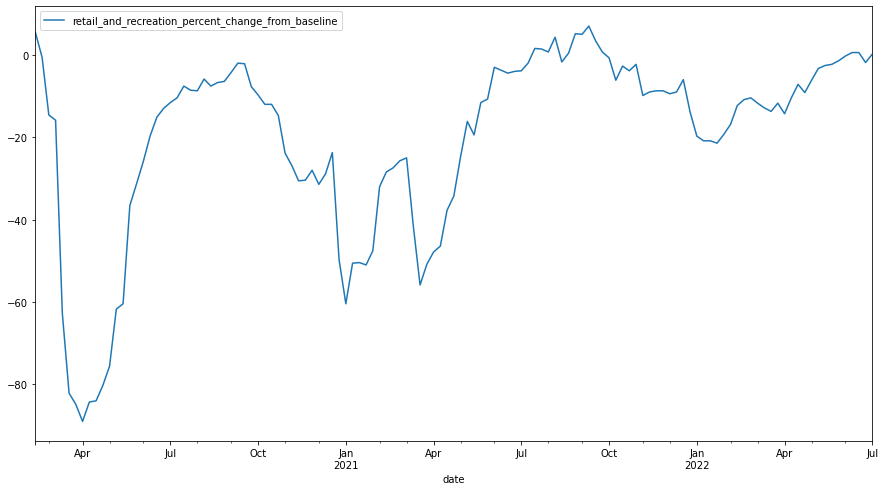

In [13]:
# plotting the data
weekly_veneto.plot(y='retail_and_recreation_percent_change_from_baseline', figsize=(15,8))

In [14]:
# We output the date of the lowest value
weekly_veneto.retail_and_recreation_percent_change_from_baseline.idxmin()

Timestamp('2020-04-05 00:00:00', freq='W-SUN')

We can see from the figure the drop in the acivity from the baseline within the region and use this to help understand the impacts of this change.

## Requesting Vessel Density Data

We retrieve vessel data from the Euro Data Cube for Venice lagoon. 

This data layer is covering only the European region and can be visualised on the EO Dashboard instance focused only on Europe. This instance is branded "Rapid Action on Covid 19 and EO (RACE)" and includes some of the datasets from the ESA-NASA-JAXA instance as well as other Europe-centric datasets. 
This dashboard instance is accessble at https://race.esa.int. 

The vessel density data visualisation in the RACE Dashboard can be inspected here: https://race.esa.int/?poi=World-E13o 

In [15]:
# let's use the IFrame to embed the vesel density map
# for a better experience, access this indicator direclty on the RACE Dashboard, at: https://race.esa.int/?poi=World-E13o 
# there you will be able to use the Draw AOI feature to generate times sereis of vessel density on your custom area.

# the view below is offering limitted functionalities.
# the 4 tabs: ALL, CARGO, TANKER, OTHERS

IFrame('https://race.esa.int/iframe?poi=World-E13o', width=800, height=500)

### Getting the actual vessel density map data

The vessel data is accessible using the Sentinel Hub service, and can be retrieve using the byoc (bring your own COG) code availble in the [Eurodatacube Collections](https://collections.eurodatacube.com/).

In [16]:
# define the area

def bbox(coord_list):
     box = []
     for i in (0,1):
         res = sorted(coord_list, key=lambda x:x[i])
         box.append((res[0][i],res[-1][i]))
     ret = f"({box[0][0]} {box[1][0]}, {box[0][1]} {box[1][1]})"
     return ret

# Parse the json here

import geojson
import shapely.wkt

# We have the POLYGON pre-defined for the Venice Lagoon. It is the same one that is used in EO Dashboard to display the Venice Water Quality Maps.

area = shapely.wkt.loads('POLYGON((12.174395 44.778037,12.196361 44.816998,12.085149 45.405263,12.426024 45.583514,13.153667 45.779148,13.603981 45.811687,13.804426 45.675662,13.823647 45.596962,13.626039 45.443008,13.549156 45.433376,13.626039 45.323461,13.713905 45.095238,13.78383 44.980605,13.830519 44.892158,13.8 44.5,12.234821 44.481556,12.06659 44.581469,12.174395 44.778037))')
gj_feat = geojson.Feature(geometry=area, properties={})

IPython.display.GeoJSON(gj_feat)

<IPython.display.GeoJSON object>

In [17]:
# we create a bounding box for the geojson 

line = bbox(list(geojson.utils.coords(gj_feat)))
print(line)

(12.06659 44.481556, 13.830519 45.811687)


In [18]:
# use the coordinates to define the boundinbox for the Venice Laggon in the Adriatic 
adriatic = [
  12.06659,
  44.481556,
  13.830519,
  45.811687
]

In [19]:
# set the resolution and create a Sentinel Hub bbox and size object

resolution = 100
adriatic_bbox = BBox(bbox=adriatic, crs=CRS.WGS84)
adriatic_size = bbox_to_dimensions(adriatic_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {adriatic_bbox} pixels')

Image shape at 100 m resolution: 12.06659,44.481556,13.830519,45.811687 pixels


In [20]:
# Define the plot_image function
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    
    ax.set_xticks([])
    ax.set_yticks([])

#### Request vessel density data from the Sentinel Hub

First we build the evalscript to request the data

In [21]:
evalscript_vessels = """
    //VERSION=3
    function setup() {
    return {
        input: [{
          bands: ["All", "dataMask"], // this sets which bands to use
        }],
        output: { // this defines the output image type
          bands: 4,
          sampleType: "UINT8"
        }
    };
}

function evaluatePixel(sample) {

  var arr = colorBlend(sample.All,    [0.5, 2, 5 , 10, 20 , 100],    
  [[0,155,143],[0,219,0],[255,252,0],[244,154,0],[208,19,0], [161,0,0] ]); 
  if (sample.dataMask==1)  arr.push(255);
  else arr.push(0);
  return arr;
}

    """

Now we request data over the lockdown period, remember we detected a low point in activity of 2020-04-05. 


In [22]:
request_vessels_covid = SentinelHubRequest(
    evalscript=evalscript_vessels,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('beee9b47-b1ab-4044-baa5-0958d3465f12'),
            time_interval=('2020-03-15', '2020-04-15'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=adriatic_bbox,
    size=adriatic_size,
    config=config
)

We set the pre-covid period one month before.

In [23]:
request_vessels_pre = SentinelHubRequest(
    evalscript=evalscript_vessels,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('beee9b47-b1ab-4044-baa5-0958d3465f12'),
            time_interval=('2020-01-15', '2020-02-15'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=adriatic_bbox,
    size=adriatic_size,
    config=config
)

#### Request vessel density map data during lockdown

In [24]:
vessel_covid = request_vessels_covid.get_data()

Image type: uint8


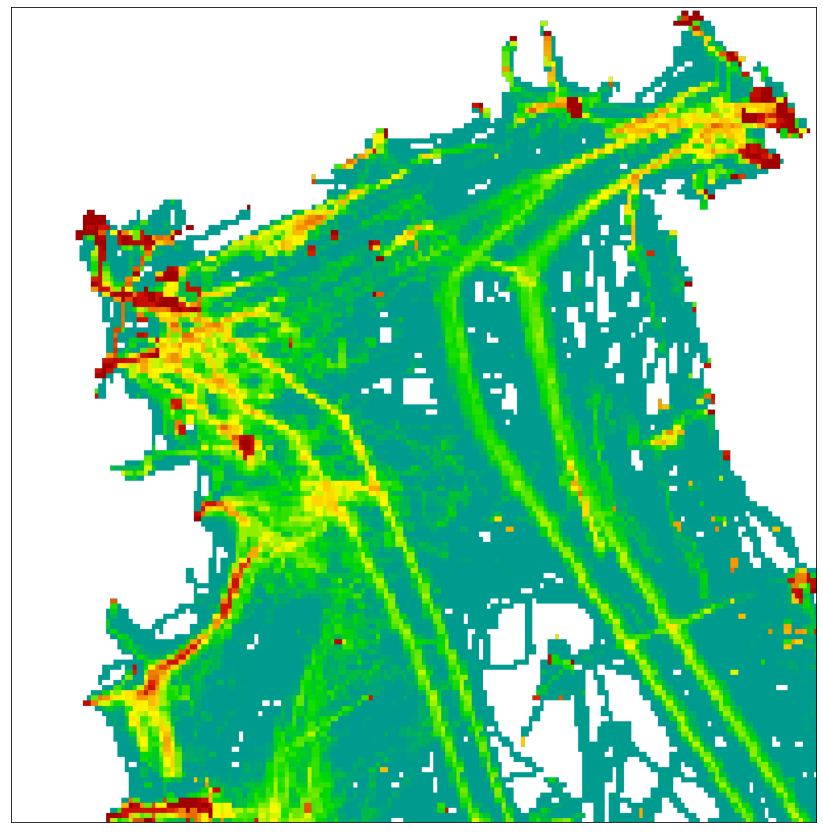

In [25]:
image = vessel_covid[0]
print(f'Image type: {image.dtype}')

# plot function
covid_data = request_vessels_covid.get_data()
plot_image(covid_data[0], factor=1 / 255)

#### Request vessel density map data before lockdown

In [26]:
vessel_pre = request_vessels_pre.get_data()

Image type: uint8


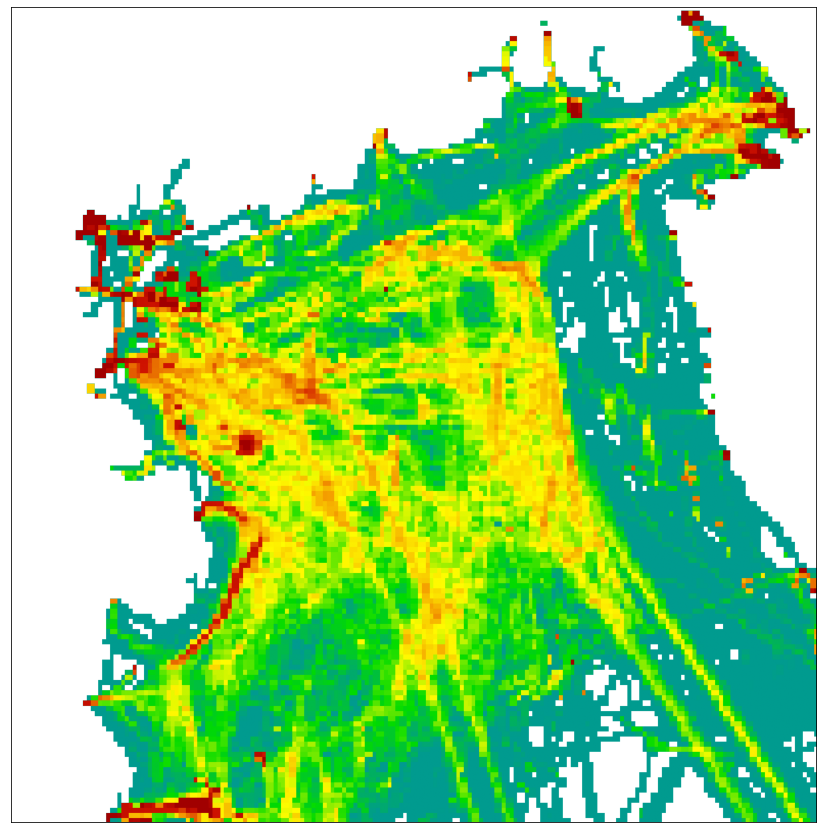

In [27]:
image = vessel_pre[0]
print(f'Image type: {image.dtype}')

# plot function
pre_data = request_vessels_pre.get_data()
plot_image(pre_data[0], factor=1 / 255)

In [28]:
# get the range of values for the vessel density maps

import numpy as np
min_pre = np.amin(pre_data[0])
max_pre = np.amax(pre_data[0])

min_post = np.amin(covid_data[0])
max_post = np.amax(covid_data[0])

print ("min value pre-lockdown:", min_pre, "max value pre-lockdown:", max_pre)
print ("min value lockdown:", min_post, "max value lockdown:", max_post)

min value pre-lockdown: 0 max value pre-lockdown: 255
min value lockdown: 0 max value lockdown: 255


The red areas indicate areas with high vessel density and the dark green areas with low density. 
From the two images we can see a clear reduction in vessel density with the data corresponding to reduced acrivity in the Veneto region.

From the [dataset documentation](https://www.emodnet-humanactivities.eu/documents/Vessel%20density%20maps_method_v1.5.pdfhttps://www.emodnet-humanactivities.eu/documents/Vessel%20density%20maps_method_v1.5.pdf) we know that the units of density in the published maps are `total ship time in hours spent in a cell over the whole month`. As the cells are 1 km , this is immediately per square km.

So every pixel in the original data has a value of `N = nr_hours x nr_ships x nr_days_in_month`

In order to obtain the density as the average number of instantaneous ships per square km, the values of the published monthly maps must be divided by the total number of hours in the month, which is 28, 30 or 31 times 24 hours depending on the month. For the published yearly average maps, the values must be multiplied by 12 and divided by 365 times 24 hours (for 2017).

To convert to ship density per square degree instead of per square km, the published numbers can be multiplied by the factor ( 60 * 1.852 )2 cos( latitude ).

**Note that in the plotted images above, the pixel values range between [0, 255]. This is due to the fact that all values above 100 hours have been capped at 255**.

### Exercise 1: Use EO Dashboard/ RACE Dashboard to extract vessel density time series

Vessel data can be accessed on the RACE Dashboard at https://race.esa.int/?poi=World-E13o

Using the Draw AOI feature, generate a time series chart. Note that the polygon information is included in the URL.
Use the information from the previously defined bounding box to customise the AOI, then regenerate the graph.
Download the CSV and import it into your workspace.

Read the CSV and plot the graph.
Can you determine significant changes in the vessel traffic from the plot?



## Using the NASA API to retrieve nightlights data

Let's inspect the Nightlights data over Venice. To inspect other locations and learn more about these datasets access this [Nightlights Story on EO Dashboard](https://eodashboard.org/story?id=nightlights) 

In [29]:
IFrame('https://eodashboard.org/explore?indicator=N5&poi=IT01-N5', width=800, height=500)

Now we retrieve nightlights data from the NASA API to check if there is a reduction in activity in the island of Venice over the covid period. The High Definition Nightlights dataset is processed to eliminate light sources like moonlight reflectance and other interferences. The darker shades are places with less light while the lighter shades of yellow are areas with more light.

The endpoints include a STAC API, which is a catalog endpoint to retrieve metadata on available datasets: https://staging-stac.delta-backend.com/docs/

The other is to render the data for which we find information in the STAC API: https://staging-raster.delta-backend.com/docs/


In [30]:
# endpoints for nasa api
STAC_ENDPOINT_URL = "https://staging-stac.delta-backend.xyz"
RASTER_ENDPOINT_URL = "https://staging-raster.delta-backend.xyz"

#### Request metadata for the nightlights data

In [31]:
# summary of the metadata for the indicator of interest
nightlights_collection_summary = re.get(f"{STAC_ENDPOINT_URL}/collections/nightlights-hd-monthly").json()
nightlights_collection_summary

{'id': 'nightlights-hd-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/nightlights-hd-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/nightlights-hd-monthly'}],
 'title': 'Black Marble High Definition Nightlights Monthly Dataset',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2017-07-21T00:00:00Z',
     '2021-09-30T23:59:59Z']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2019-01-01T00:00:00Z', '2022-03-01T00:00:00Z'],
  'cog_default': {'max': 255, 'min': 0}},
 'description': 'The High Definition Nightlights dataset is processed to eliminate lig

#### Request nightlights data before lockdown

In [32]:
# retrieving a pre-covid image from the STAC API

response_pre = re.post(
    f"{STAC_ENDPOINT_URL}/search", 
    json={
        "collections": ["nightlights-hd-monthly"],
        "query": {"datetime": {"eq":"2019-04-01T00:00:00"}},
        "limit": 100
    }
).json()
item_pre = response_pre["features"][0]

In order to render the image correctly you must define the visualisation parameters, which will differ between datasets. Here in the [documentation](https://staging-raster.delta-backend.com/docs#/Cloud%20Optimized%20GeoTIFF/preview_cog_preview__format__get) you can input the correct visualisation parameters and generate an output, this will help you to form the request within the notebook.

In [33]:
# rendering the image with the RASTER API
tiles_pre_covid = re.get(
    f"{RASTER_ENDPOINT_URL}/stac/tilejson.json?collection={item_pre['collection']}&item={item_pre['id']}&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=plasma", 
).json()
tiles_pre_covid

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nightlights-hd-monthly&item=finalBMHD_ScaledVenice_201904&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=plasma'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [11.7631744, 45.06062636, 12.79039608, 45.79310055],
 'center': [12.27678524, 45.426863455, 0]}

#### Request nightlights data during lockdown

In [34]:
# retrieving a covid image from the STAC API

response_nasa_covid = re.post(
    f"{STAC_ENDPOINT_URL}/search", 
    json={
        "collections": ["nightlights-hd-monthly"],
        "query": {"datetime": {"eq":"2020-04-01T00:00:00"}},
        "limit": 100
    }
).json()
item_covid = response_nasa_covid["features"][0]

In [35]:
tiles_covid = re.get(
    f"{RASTER_ENDPOINT_URL}/stac/tilejson.json?collection={item_covid['collection']}&item={item_covid['id']}&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=plasma", 
).json()
tiles_covid

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.xyz/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nightlights-hd-monthly&item=finalBMHD_ScaledVenice_202004&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=plasma'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [11.7631744, 45.06062636, 12.79039608, 45.79310055],
 'center': [12.27678524, 45.426863455, 0]}

### Directly compare the two images

In [36]:
# set map parameters
center = [45.438558, 12.333421]
zoom = 13

In [37]:
# display interactive map
m = Map(center=center, zoom=zoom)
m

Map(center=[45.438558, 12.333421], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [38]:
left = TileLayer(url=tiles_pre_covid["tiles"][0])
right = TileLayer(url=tiles_covid["tiles"][0])

control = SplitMapControl(left_layer=left, right_layer=right)
m.add_control(control)

The darker areas indicate a reduction in luminosity and the yellow areas higher luminosity, when comparing the two images we can see a reduction in activity over the covid period.

### Retrieving Sentinel 2 imagery over the Island of Venice
Now we have identified the drop in activity due to the lockdown conditions we can retrieve the satellite images to see if there is a corresponding impact visable.

[Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a multispectral satellite with 13 spectral bands, launched in 2016. We use the Red, Green and Blue bands to contruct a true colour image over the island of Vencie from August 2019 to August 2020.

This data is stored in the Sentinel Hub, for more infomation on the dataset and parameters visit the [documentation.](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/)

First we define a bounding box for our area of intrest. An easy way to do this is using the [SH Request Builder.](https://apps.sentinel-hub.com/requests-builder/)


In [39]:
# defining our bbox over the island of Venice

venice = [
  12.296613,
  45.411707,
  12.393469,
  45.469281
]

In [40]:
#Set the resolution and create a sentinel hub bbox and size object

resolution = 10
venice_bbox = BBox(bbox=venice, crs=CRS.WGS84)
venice_size = bbox_to_dimensions(venice_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {venice_bbox} pixels')

Image shape at 10 m resolution: 12.296613,45.411707,12.393469,45.469281 pixels


Below we use the [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) to define the metadata and preprocessing for RGB Sentinel-2 imagery from the Sentinelhub.

In [41]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

In [42]:
# We create a list of dates for retreiving multiple images

start = datetime.datetime(2019,8,1)
end = datetime.datetime(2020,8,1)
n_chunks =13
tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

Monthly time windows:

('2019-08-01', '2019-08-29')
('2019-08-29', '2019-09-26')
('2019-09-26', '2019-10-24')
('2019-10-24', '2019-11-21')
('2019-11-21', '2019-12-19')
('2019-12-19', '2020-01-16')
('2020-01-16', '2020-02-14')
('2020-02-14', '2020-03-13')
('2020-03-13', '2020-04-10')
('2020-04-10', '2020-05-08')
('2020-05-08', '2020-06-05')
('2020-06-05', '2020-07-03')


In [43]:
# define the function to retreive the image
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=venice_bbox,
        size=venice_size,
        config=config
    )

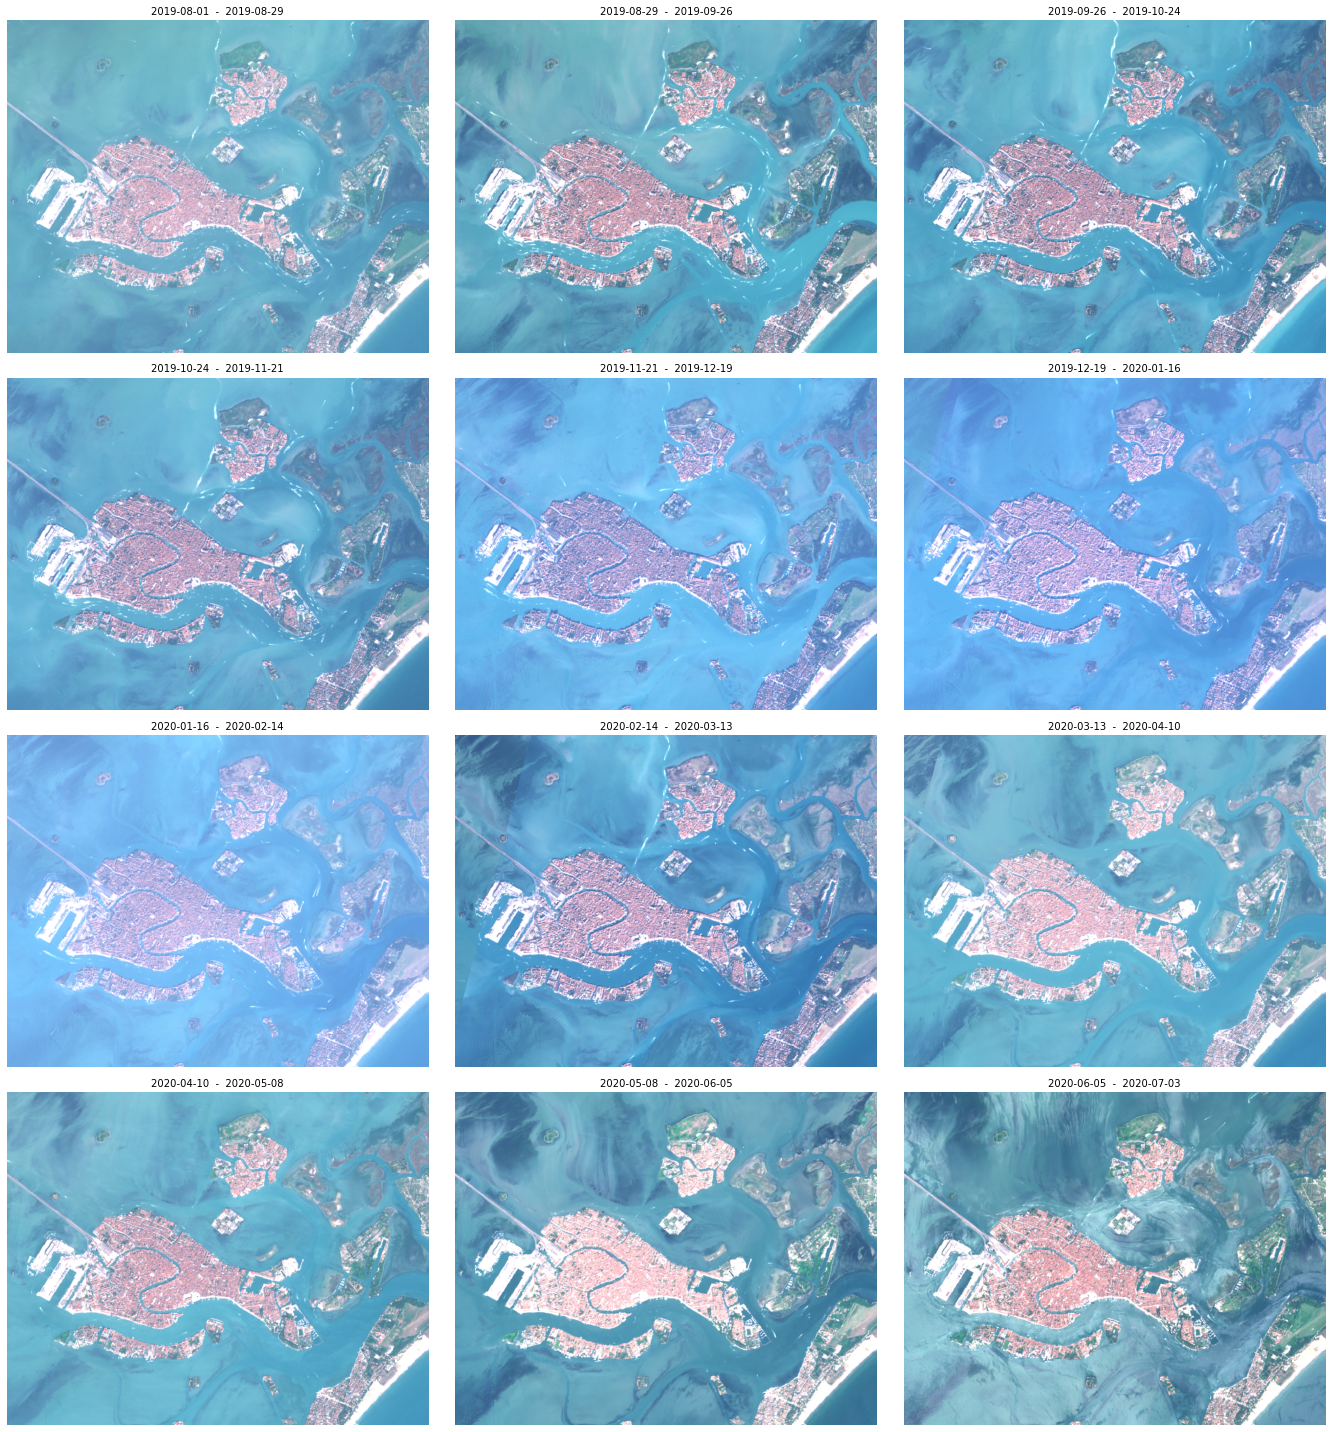

In [44]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
# some stuff for pretty plots
ncols = 3
nrows = 4
aspect_ratio = venice_size[0] / venice_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()

From the images we can see a sharp reduction in the amount of boats which are travelling around the Island of Venice, and a corresponding impovement in the water quality.

## Requesting Water Quality Data from JAXA

In order to test our theory about the improved water quality we use JAXA water quality data, specifically [water quality Chlorophyll-a weekly anomaly](https://collections.eurodatacube.com/jaxa_wq_chla/).

As data is stored in the Sentinel Hub we use a similar syntax as above to retrieve the data but instead define the byoc code, stated in the documentation.

We will request this data using the Adriatic boundinbox.

In [45]:
evalscript_jaxa = """
    //VERSION=3
    function setup() {
      return {
        input: ["chla"],
        output: { bands: 1,
          sampleType: "UINT8" }
      };
    }
    function evaluatePixel(sample) {
        return [sample.chla];
    }
    """

In [46]:
#defining the request
request_jaxa = SentinelHubRequest(
    evalscript=evalscript_jaxa,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('198aa13a-b0c0-4b78-8f69-e08fc58551a7'),  #('4f5f67f1-5715-4f2b-8c98-ae57948ee2f5'),
            time_interval=('2020-03-15', '2020-04-15'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=adriatic_bbox,
    size=adriatic_size,
    config=config
)

jaxa = request_jaxa.get_data()

Image type: uint8


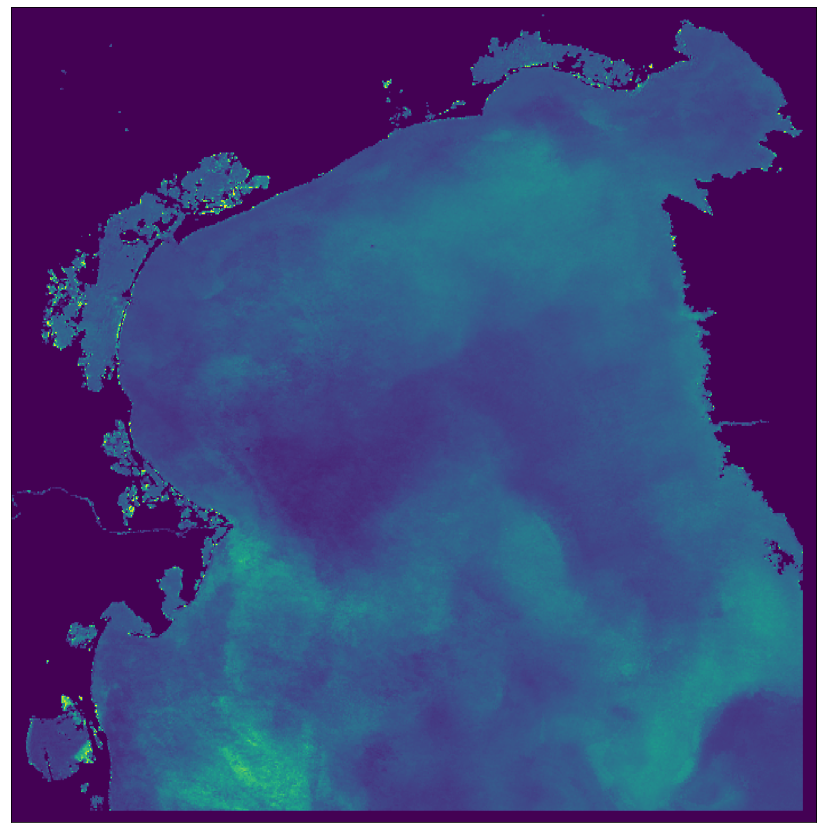

In [47]:
# retreiving a single image
image = jaxa[0]
print(f'Image type: {image.dtype}')

# plot function
plot_image(jaxa[0], factor=1 / 255)

In [48]:
def get_water_quality_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_jaxa,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc('198aa13a-b0c0-4b78-8f69-e08fc58551a7'),
                time_interval=time_interval
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=adriatic_bbox,
        size=adriatic_size,
        config=config
    )

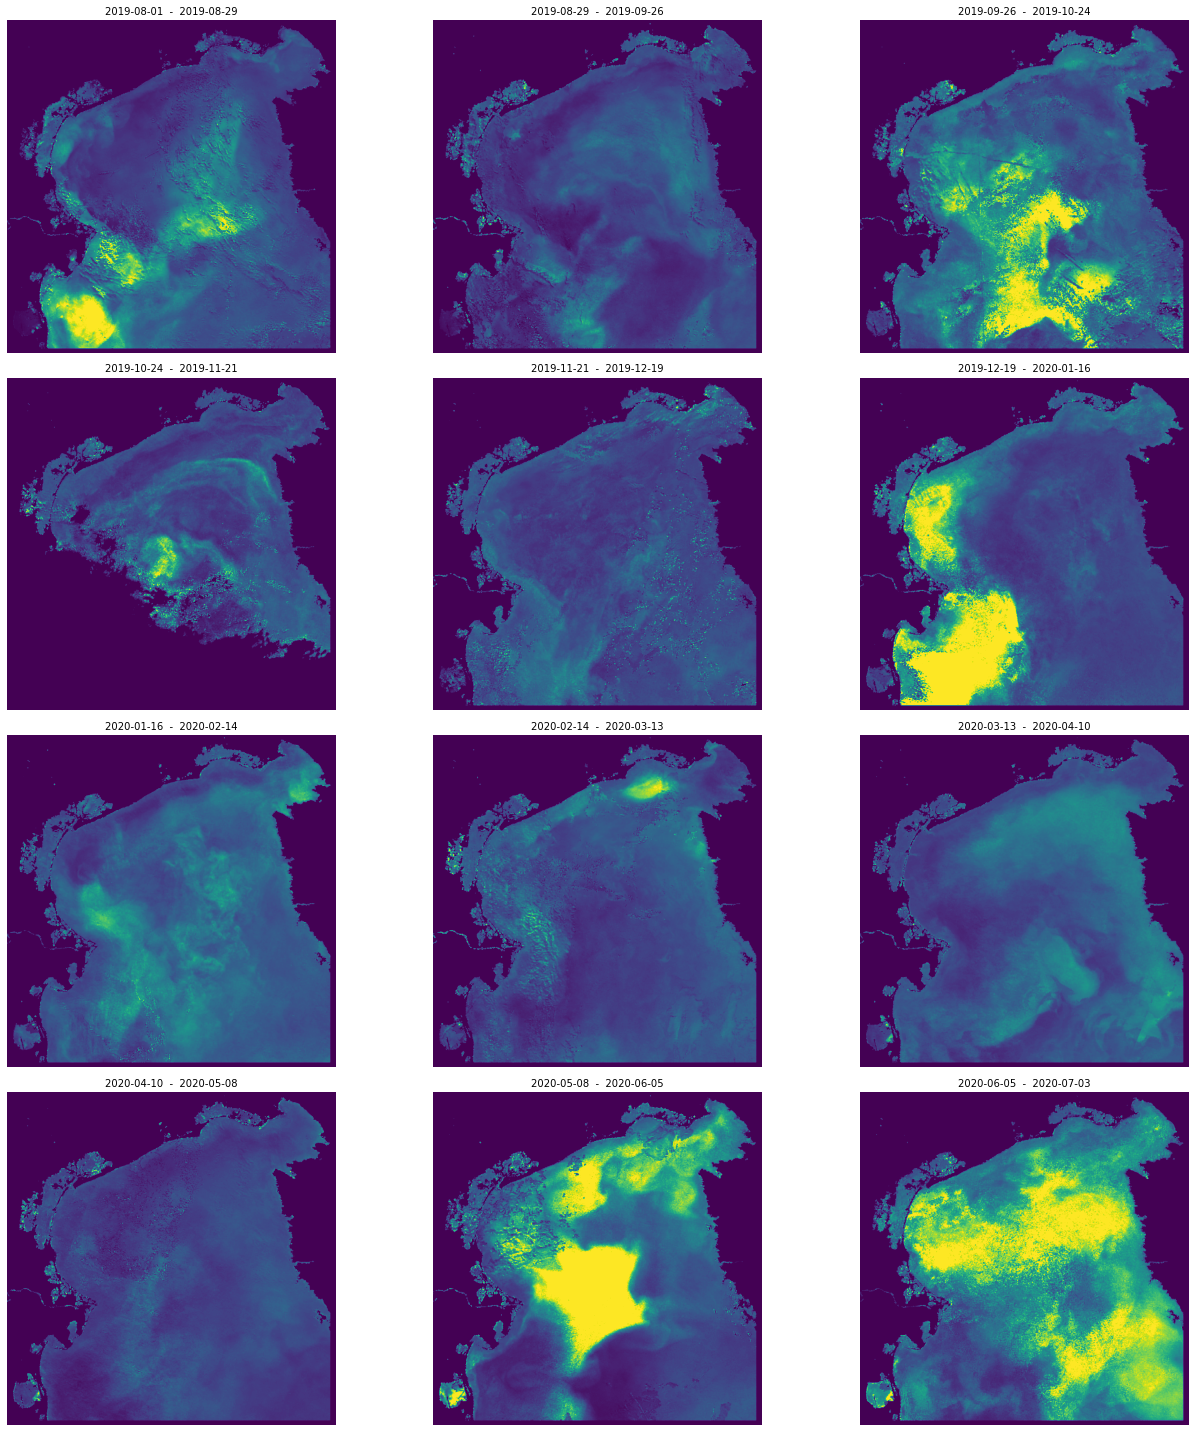

In [49]:
# create a list of requests

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm 

list_of_requests = [get_water_quality_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
# some stuff for pretty plots
ncols = 3
nrows = 4
aspect_ratio = venice_size[0] / venice_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 1/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)
plt.tight_layout()

The range lies from 0-1 (blue to yellow), 0 being no anomaly in chlorophyll-a and the 1 being high anomaly. From a first look at the images it is hard to make robust conclusions on the water quality. However the image retrieved over the period of the first lockdown does seem to have the lowest anomalies.

### Exercise 2: Retrieving Water Quality Datasets from the SentinelHub

Search the edc collections and retrieve a different [water quality product.](https://collections.eurodatacube.com/)

Copy the above structure to access another water quality dataset, you will need to change some parameters.


## Retrieving water quality time series from GeoDB

On EO Dahboard we also have access to Chlorophyll a and Total Suspended Sediments time sereis data on a number of locations, including Venice.
You can inspect these time series on the dashboard at: https://eodashboard.org/explore?indicator=N3b

For Venice, the time series is available here: https://eodashboard.org/explore?indicator=N3b&poi=IT6-N3b

The displayed time series show weekly Chl concentration anomalies (%) as calculated from Sentinel-3 (purple), MODIS (blue) and GCOM-C(light blue) around the Alta Aqua Oceanographic Tower (AAOT at 45.30 N, 12.50 E) in the North Adriatic Sea, the Mediterranean sub-basin most influenced by river runoff, in particular by the Po River, which is the largest river in Italy and which runs along many different industrialized areas.

On EO Dashboard we can see that the measurements from the three sensors on Sentinel3, MODIS and GCOM-C are in agreement.

We could go a bit deeper in the analysis if we only focus on the Sentinel3 data, where we have access to the same time series but compared to the climatology. This graph is not available on EO Dashboard, but we can visualise it on The RACE platform. 
This data is stored in the EuroDataCube GeoDB.

(For a complete overview of where the data is available please use the DataAccess.jpynb).

https://race.esa.int/?indicator=N3&poi=IT6-N3 

In [50]:
geodb_database = "eodash"
geodb_collection = "N3"

In [51]:
data = geodb.get_collection(collection=geodb_collection, database=geodb_database)
data.head()

id                        created_at modified_at  \
0   1  2021-01-21T16:51:28.038108+00:00        None   
1   2  2021-01-21T16:51:28.038108+00:00        None   
2   3  2021-01-21T16:51:28.038108+00:00        None   
3   4  2021-01-21T16:51:28.038108+00:00        None   
4   5  2021-01-21T16:51:28.038108+00:00        None   

                    geometry                  aoi country              region  \
0  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
1  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
2  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
3  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   
4  POINT (12.50806 45.31425)  45.314247,12.508055      IT  North Adriatic Sea   

            city                   site_name                description  ...  \
0  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
1  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
2  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
3  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   
4  Venice Lagoon  AAOT fixed station Venezia  Water Quality Time Series  ...   

  reference_value                                               rule  \
0     [-999 -999]  Measurement < Reference [0] outputs LOW; Refer...   
1  [-0.139 0.044]  Measurement < Reference [0] outputs LOW; Refer...   
2  [-0.158 0.083]  Measurement < Reference [0] outputs LOW; Refer...   
3  [-0.138 0.099]  Measurement < Reference [0] outputs LOW; Refer...   
4  [-0.455 0.335]  Measurement < Reference [0] outputs LOW; Refer...   

  indicator_value sub_aoi                                y_axis  \
0               /       /  Chlorophyll-a concentration [mg m-3]   
1               /       /  Chlorophyll-a concentration [mg m-3]   
2          NORMAL       /  Chlorophyll-a concentration [mg m-3]   
3             LOW       /  Chlorophyll-a concentration [mg m-3]   
4             LOW       /  Chlorophyll-a concentration [mg m-3]   

                                      indicator_name color_code data_provider  \
0  Chlorophyll-a concentration at AAOT fixed stat...          /     CNR-ISMAR   
1  Chlorophyll-a concentration at AAOT fixed stat...          /     CNR-ISMAR   
2  Chlorophyll-a concentration at AAOT fixed stat...       BLUE     CNR-ISMAR   
3  Chlorophyll-a concentration at AAOT fixed stat...      GREEN     CNR-ISMAR   
4  Chlorophyll-a concentration at AAOT fixed stat...      GREEN     CNR-ISMAR   

  aoi_id update_frequency  
0    IT6           Weekly  
1    IT6           Weekly  
2    IT6           Weekly  
3    IT6           Weekly  
4    IT6           Weekly  

[5 rows x 28 columns]

In [52]:
# display the locations of the data
cities = geodb.get_collection_pg(geodb_collection, database=geodb_database, group='city, geometry', select='city, geometry')

features = json.loads(cities.to_json())

IPython.display.GeoJSON(features)
    

<IPython.display.GeoJSON object>

In [53]:
def plot_city(city=cities.city[0]):
    #A bit hidden in this function lies the query against the RACE collection of interest.
    gdf = geodb.get_collection(geodb_collection, database=geodb_database, query=f"city=eq.{city}")
    
    # A bit if data cleaning to get this working as None values are given as '/'
    gdf = gdf.drop(gdf[gdf.indicator_value == "/"].index)
    
    indicator_values = geodb.get_collection_pg(geodb_collection, database=geodb_database, group='indicator_value', select='indicator_value')
    
    # A bit if data cleaning to get this working as None values are given as '/'
    indicator_values = indicator_values.drop(indicator_values[indicator_values.indicator_value == "/"].index)
    
    gdf['time'] = pd.to_datetime(gdf.time)
    gdf['measurement_value']  = gdf.measurement_value.astype(float)
    source = ColumnDataSource(data=dict(time=gdf.time, measurement_value=gdf.measurement_value, indicator_value=gdf.indicator_value))
    
    p = figure(x_axis_type='datetime', width=800)
    p.title.text = geodb_collection + " in " +  city
    p.title.align = "center"
    p.title.text_font_size = "25px"

    p.vbar(x='time', top='measurement_value', legend_field="indicator_value", line_width=2, fill_color=factor_cmap('indicator_value', palette=Spectral3, factors=indicator_values.indicator_value), line_color=factor_cmap('indicator_value', palette=Spectral3, factors=indicator_values.indicator_value), source=source)

    show(p)

Now we plot the cities with insitu water quality timeseries for the Venice lagoon.

In [54]:
# Generate a unique list of cities
output_notebook()
cities = geodb.get_collection_pg(geodb_collection, database=geodb_database, group='city', select='city')

interact(plot_city, city=cities.city[0]);

Loading BokehJS ...

interactive(children=(Text(value='Venice Lagoon', description='city'), Output()), _dom_classes=('widget-intera…

### Exercise 3 ###

Can you make some conclusions from the time series? This event has been studied at length in the literature, this [paper](https://www.sciencedirect.com/science/article/pii/S0048969722000912) can be a starting point for some ideas on how to improve the method.

There could be another reason for the change in water quality in the region, the largest river in Italy is located just below Venice. Can you preform some anaylsis to investigate this further?